# Imports

In [9]:
import pandas as pd
import time

from tqdm.notebook import tqdm
from IPython.display import clear_output

import matplotlib.pyplot as plt
import seaborn as sns

import tweepy
from auth import auth #Inserir autenticação no arquivo auth.py
#from grabel_auth import auth

import warnings
warnings.filterwarnings('ignore')

# API object

* [AUTENTICAÇÕES DO TWITTER](https://bhaskarvk.github.io/2015/01/how-to-use-twitters-search-rest-api-most-effectively./#:~:text=Application%20only%20auth%20has%20higher,Auth%20using%20the%20Tweepy%20API.)

In [2]:
tt = auth()

# Functions

## count_down

In [4]:
# count down
def count_down(tempo):
    while tempo:
        mins, secs = divmod(tempo, 60)
        timeformat = '{:02d}:{:02d}'.format(mins, secs)
        print(timeformat, end='\r')
        time.sleep(1)
        tempo -= 1

In [5]:
count_down(10)

## get_followers_id()

In [6]:
# get_followers_id()

def get_followers_ids(perfil_analisado):
    '''Recebe um nome de perfil do twitter e retorna serie com ids dos seguidores'''
    ids = []
    my_pages = tweepy.Cursor(tt.followers_ids, screen_name=perfil_analisado).pages()
    while True:
        try:
            page = my_pages.next()
            ids.extend(page)
            time.sleep(2)
        except tweepy.TweepError:
                tempo = (60 * 15) #15 min
                time.sleep(tempo)
                print('oi')
                while tempo:
                    mins, secs = divmod(tempo, 60)
                    timeformat = '{:02d}:{:02d}'.format(mins, secs)
                    print(timeformat, end='\r')
                    time.sleep(1)
                    tempo -= 1 #não está printando a contagem regressiva!
                continue
        except StopIteration:
            break
  
    return pd.DataFrame(ids, columns=['followers_ids'])['followers_ids']


* Exemplo:

In [7]:
followers = get_followers_ids('grabel')
len(followers)

Rate limit reached. Sleeping for: 512


171

## get_users_data()

In [6]:
# get_users_data()
def get_users_data(lista_ids):
    '''Recebe lista ou serie de ids e retorna nomes de perfis do twitter'''
    followers = pd.DataFrame()
    while len(lista_ids)>len(followers):
        try:
            for tt_id in tqdm(lista_ids):
                df = pd.DataFrame(tt.get_user(tt_id)._json)
                df = df.loc[['description'],['id_str','name','screen_name','profile_image_url_https',
                                             'description','statuses_count','friends_count','followers_count',
                                             'favourites_count','location','created_at','protected','lang']].rename(
                                                                                    columns={
                                                                                              'statuses_count':'tweets_count',
                                                                                              'id_str':'profile_id'
                                                                                              })
                followers = pd.concat([followers, df], axis = 0, ignore_index=True)  
                time.sleep(.5)
                
        except tweepy.TweepError:
                tempo = (60 * 15) #15 min
                time.sleep(tempo)
                count_down(tempo)
                continue
        except StopIteration:
            break
        
    return followers

* Exemplo:

In [7]:
df_users = get_users_data(followers[:2])
df_users.head()

,profile_id,name,screen_name,profile_image_url_https,description,tweets_count,friends_count,followers_count,favourites_count,location,created_at,protected,lang
0,1291458785853284352,Jornal Botucatu em 🏠 ✪,jornalBotucatu,https://pbs.twimg.com/profile_images/129171464...,⌚𝐉𝐨𝐫𝐧𝐚𝐥 𝐛𝐨𝐭𝐮𝐜𝐚𝐭𝐮⌚\n\n ☭ noticias atualizadas\n...,39,62,15,119,,Thu Aug 06 19:39:13 +0000 2020,False,None
1,975585204441174016,Diego de Oliveira,jose_goday,https://pbs.twimg.com/profile_images/129286964...,Escritor e barraqueiro digital,2748,683,1167,3240,,Mon Mar 19 04:10:13 +0000 2018,False,None


## get_followers_data()

In [8]:
# get_followers_data()
def get_followers_data(perfil_analisado):
    '''Recebe perfil e retorna dataframe com dados das páginas dos seguidores'''
    df_fol = get_followers_ids(perfil_analisado)
    return get_users_data(df_fol)

* Exemplo:

In [9]:
df_followers = get_followers_data('grabel')
df_followers.head().style

,profile_id,name,screen_name,profile_image_url_https,description,tweets_count,friends_count,followers_count,favourites_count,location,created_at,protected,lang
0,1291458785853284352,Jornal Botucatu em 🏠 ✪,jornalBotucatu,https://pbs.twimg.com/profile_images/1291714645779197952/6bAyDIbu_normal.jpg,⌚𝐉𝐨𝐫𝐧𝐚𝐥 𝐛𝐨𝐭𝐮𝐜𝐚𝐭𝐮⌚ ☭ noticias atualizadas (eh só um jornal engraçadinho) ☎faltou alguma noticia? mande nos!☎ ☭ jornalnewsbotucatu@gmail.com ☭,39,62,15,119,,Thu Aug 06 19:39:13 +0000 2020,False,None
1,975585204441174016,Diego de Oliveira,jose_goday,https://pbs.twimg.com/profile_images/1292869643770769409/A3fyDZ_x_normal.jpg,Escritor e barraqueiro digital,2748,683,1167,3240,,Mon Mar 19 04:10:13 +0000 2018,False,None
2,123057045,exaustinha,rubacaozin,https://pbs.twimg.com/profile_images/1287814896982392832/o6ORPRSe_normal.jpg,bota o vídeo no mudo e toca tame impala,12255,479,1024,27751,"Brazil, IN",Sun Mar 14 21:11:41 +0000 2010,False,None
3,1284136441984036865,Lilly Lazuli 🌛✨,LazuliLilly,https://pbs.twimg.com/profile_images/1284138099535159297/ve5jnCIx_normal.jpg,Self-proclaimed indecisive overthinker. 27 y.,41,33,16,190,,Fri Jul 17 14:42:48 +0000 2020,True,None
4,426770605,Arte_pincel,Arte_Pincel,https://pbs.twimg.com/profile_images/1284265135259910145/MiLJbIh4_normal.jpg,AS ARTE PLASTICAS DOS LAPES A VÉRBERTY LIBRAS E ARTE VIA FRANÇA PRIAS DE @ARTE_PINCEL ITÁLIA OBRIGADO !!!!,947,2595,425,628,"Campina Grande, Brasil",Fri Dec 02 17:32:45 +0000 2011,False,None


## get_seguidores_iguais()

In [10]:
# get_seguidores_iguais()
def get_seguidores_iguais(*tt_users):
    '''Recebe nomes de perfis do twitter e retorna serie com seguidores em comum.'''
    
    tt_users = list(tt_users) 
    print('Perfis a filtrar:', len(tt_users))
    if len(tt_users)>=2:
                    
        fols_user1 = get_followers_ids(tt_users.pop(0))
        
        clear_output(wait=True)
        print('Perfis a filtrar:', len(tt_users))
        fols_user2 = get_followers_ids(tt_users.pop(0))
        df_both = pd.merge(fols_user2, fols_user1, how = 'inner', on='followers_ids')
        
        while len(tt_users)>=1:
            
            clear_output(wait=True)
            print('Perfis a filtrar:', len(tt_users))
            
            fols_userx = get_followers_ids(tt_users.pop(0))
            df_both = pd.merge(df_both, fols_userx, how='inner', on ='followers_ids')
           
        clear_output(wait=True)
        print('Seguidores em comum: ', len(df_both))
        
    return get_users_data(df_both['followers_ids'])  

* Exemplo:

In [11]:
seguidores_em_comum = get_seguidores_iguais('grabel',
                                            'mandielima', 
                                            'iasdoar', 
                                            'anaraissans'
                                             )

Seguidores em comum:  4


In [28]:
seguidores_em_comum #Exibe os dados dos seguidores em comum

,profile_id,name,screen_name,profile_image_url_https,description,tweets_count,friends_count,followers_count,favourites_count,location,created_at,protected,lang
0,158857500,Anakin Skywalker,jeronimoisabela,https://pbs.twimg.com/profile_images/290812783...,,12317,418,486,13645,,Wed Jun 23 21:05:31 +0000 2010,False,None
1,34309517,tsrd,tayase,https://pbs.twimg.com/profile_images/129463565...,chalálálánem,19361,375,217,10301,"João Pessoa, PB.",Wed Apr 22 15:57:02 +0000 2009,True,None
2,43043000,BemVS,bemlucas,https://pbs.twimg.com/profile_images/103991165...,o mal é bom e o Bem cruel,8591,582,540,29517,"João Pessoa, Brasil",Thu May 28 04:01:11 +0000 2009,False,None
3,200278803,emo & muito cult,paleshtrinha,https://pbs.twimg.com/profile_images/129108506...,"milionária, linda, estylosa, simpática, preta ...",94345,253,339,33,,Fri Oct 08 22:14:32 +0000 2010,True,None


## plot_tt_top()

In [20]:
# plot_tt_top()
def plot_tt_top(df = [], top=10, table = False):
        
    l = 25
    h = min(top*2.2, 150)
    cols = {'flls':'followers_count',
            'frds':'friends_count',
            'twts':'tweets_count',
            'favs':'favourites_count'}
    
    ind = "?"
    while ind not in cols.keys():
        ind = input('''Digite um dos valores para organizar o plot:
                       flls : número de seguidores;
                       frds : número de amigos;
                       twts : número de tweets;
                       favs : número de favoritagens.\n''')
        if ind not in cols.keys():
            print('Valor não aceito!\n')
    
    param = cols.get(ind)
    
    df_plot = df.set_index('screen_name').nlargest(top, param)
    df_plot.sort_values(param)[cols.values()].plot(kind='barh', 
                                                   figsize=[l, h], 
                                                   #width = .8,
                                                   grid = True
                                                    )
    if table:
            return df_plot[cols.values()].style.background_gradient(cmap='Greens')
            
    plt.title('Top {} por {}'.format(top, param))    
    plt.ylabel('')
    plt.show()

* Exemplo:

Digite um dos valores para organizar o plot:
                       flls : número de seguidores;
                       frds : número de amigos;
                       twts : número de tweets;
                       favs : número de favoritagens.
flls


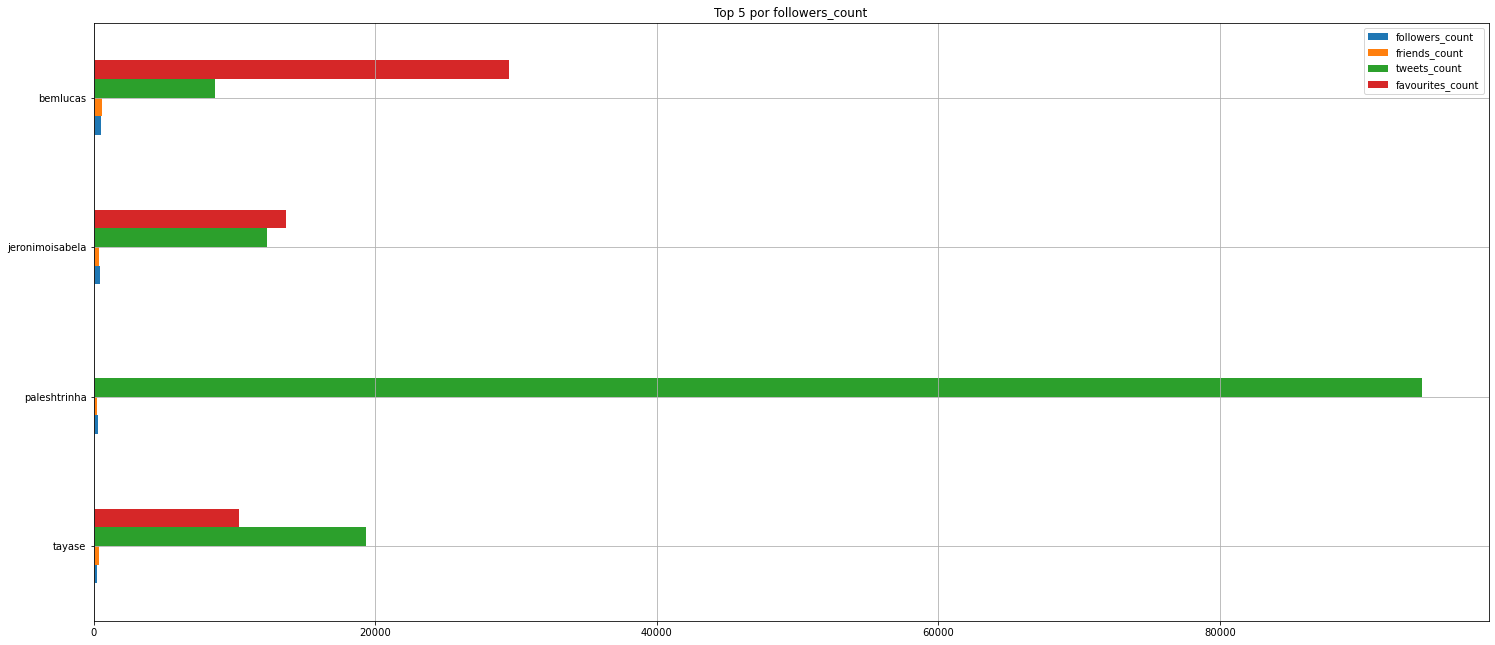

In [21]:
df = seguidores_em_comum

plot_tt_top(df,            #Dataframe com dados do twitter 
            top = 5,       #Tamanho do top por parâmetro definido
            table = False  #Exibe ou não tabela de resumo dos dados
           )

#PS.: Dois cliques para ampliar o gráfico!

# Pesquisas no twitter

In [14]:
# --Criar função e controlar número de solicitações!
tts = []
for tweet in tweepy.Cursor(tt.search,
                           q="biscoito"
                           ,since="2020-08-17"
                          # ,until="2020-08-06"
                         #  ,lang="pt"
                          ).items(5): #Retornando apenas 5 tweets
    try:
        tts.append(list((tweet.created_at, tweet.text)))
    except tweepy.TweepError:
        time.sleep(60 * 15)
        count_down(60 * 15)
        continue
    except StopIteration:
        break
    

In [15]:
tts

[[datetime.datetime(2020, 8, 17, 20, 38, 46),
  'biscoito pra yuki chavosa pf https://t.co/FwvBlxmZLV'],
 [datetime.datetime(2020, 8, 17, 20, 38, 42),
  'RT @LorannyBL: Lorenna tá comendo biscoito deitada igual patroa 🤣🤣 \nEssa menina é um abuso'],
 [datetime.datetime(2020, 8, 17, 20, 38, 38),
  'RT @gangsterdudaa: EXPOSED\nretuitem e façam esse EXPOSED chegar em geral \n\nOntem a noite peguei um uber (Dalton Camara de souza, placa PVL…'],
 [datetime.datetime(2020, 8, 17, 20, 38, 33),
  'vou comer biscoito de morango com iogurte de morango'],
 [datetime.datetime(2020, 8, 17, 20, 38, 31),
  'Tou observando a militância da maioria por um caso que repercutiu nacionalmente, por puro biscoito. E quando aconte… https://t.co/uB0TF2lvvD']]